### Problem Statement and Justification

Our project aims to identify key characteristics of games on the Steam platform that correlate with high user ratings and positive reception. This can help game developers prioritize features and design choices that improve user satisfaction. Beyond this, we aim to critically assess whether our model's predictions promote features associated with unhealthy player behavior (e.g., grindy loops, pay-to-win mechanics) or exhibit bias toward certain genres or communities. The end goal is to build a model that is both predictive and ethically aware.

### Import Packages

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from collections import Counter
from sklearn.preprocessing import MultiLabelBinarizer, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier

### Data Cleaning/Preparation and EDA

In [19]:
# Import file and skip issue lines
df = pd.read_csv("games.csv", on_bad_lines='skip')

# Check shape and preview
print(df.shape)
df.head()

(111452, 39)


,AppID,Name,Release date,Estimated owners,Peak CCU,Required age,Price,DiscountDLC count,About the game,Supported languages,...,Average playtime two weeks,Median playtime forever,Median playtime two weeks,Developers,Publishers,Categories,Genres,Tags,Screenshots,Movies
20200,Galactic Bowling,"Oct 21, 2008",0 - 20000,0,0,19.99,0,0,Galactic Bowling is an exaggerated and stylize...,['English'],...,0,0,0,Perpetual FX Creative,Perpetual FX Creative,"Single-player,Multi-player,Steam Achievements,...","Casual,Indie,Sports","Indie,Casual,Sports,Bowling",https://cdn.akamai.steamstatic.com/steam/apps/...,http://cdn.akamai.steamstatic.com/steam/apps/2...
655370,Train Bandit,"Oct 12, 2017",0 - 20000,0,0,0.99,0,0,THE LAW!! Looks to be a showdown atop a train....,"['English', 'French', 'Italian', 'German', 'Sp...",...,0,0,0,Rusty Moyher,Wild Rooster,"Single-player,Steam Achievements,Full controll...","Action,Indie","Indie,Action,Pixel Graphics,2D,Retro,Arcade,Sc...",https://cdn.akamai.steamstatic.com/steam/apps/...,http://cdn.akamai.steamstatic.com/steam/apps/2...
1732930,Jolt Project,"Nov 17, 2021",0 - 20000,0,0,4.99,0,0,Jolt Project: The army now has a new robotics ...,"['English', 'Portuguese - Brazil']",...,0,0,0,Campião Games,Campião Games,Single-player,"Action,Adventure,Indie,Strategy",NaN,https://cdn.akamai.steamstatic.com/steam/apps/...,http://cdn.akamai.steamstatic.com/steam/apps/2...
1355720,Henosis™,"Jul 23, 2020",0 - 20000,0,0,5.99,0,0,HENOSIS™ is a mysterious 2D Platform Puzzler w...,"['English', 'French', 'Italian', 'German', 'Sp...",...,0,0,0,Odd Critter Games,Odd Critter Games,"Single-player,Full controller support","Adventure,Casual,Indie","2D Platformer,Atmospheric,Surreal,Mystery,Puzz...",https://cdn.akamai.steamstatic.com/steam/apps/...,http://cdn.akamai.steamstatic.com/steam/apps/2...
1139950,Two Weeks in Painland,"Feb 3, 2020",0 - 20000,0,0,0.00,0,0,ABOUT THE GAME Play as a hacker who has arrang...,"['English', 'Spanish - Spain']",...,0,0,0,Unusual Games,Unusual Games,"Single-player,Steam Achievements","Adventure,Indie","Indie,Adventure,Nudity,Violent,Sexual Content,...",https://cdn.akamai.steamstatic.com/steam/apps/...,http://cdn.akamai.steamstatic.com/steam/apps/2...


In [20]:
# General info
df.info()

# Check missing values
df.isnull().sum()

# Descriptive statistics
df.describe(include='all')

# Number of unique values per column
df.nunique()

<class 'pandas.core.frame.DataFrame'>
Index: 111452 entries, 20200 to 3183790
Data columns (total 39 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   AppID                       111446 non-null  object 
 1   Name                        111452 non-null  object 
 2   Release date                111452 non-null  object 
 3   Estimated owners            111452 non-null  int64  
 4   Peak CCU                    111452 non-null  int64  
 5   Required age                111452 non-null  float64
 6   Price                       111452 non-null  int64  
 7   DiscountDLC count           111452 non-null  int64  
 8   About the game              104969 non-null  object 
 9   Supported languages         111452 non-null  object 
 10  Full audio languages        111452 non-null  object 
 11  Reviews                     10624 non-null   object 
 12  Header image                111452 non-null  object 
 13  Website       

,0
AppID,110325
Name,4939
Release date,14
Estimated owners,1760
Peak CCU,19
Required age,756
Price,43
DiscountDLC count,98
About the game,104404
Supported languages,14861


In [21]:
# Drop sparse/unnecessary columns
df.drop(columns=[
    'Notes', 'Metacritic url', 'Support email', 'Support url',
    'Header image', 'Website', 'Score rank', 'Movies', 'Screenshots'
], inplace=True, errors='ignore')

# Parse dates
df['Release date'] = df['Release date'].apply(pd.to_datetime, errors='coerce')

# Fill missing game descriptors
for col in ['Developers', 'Publishers', 'Genres', 'Categories', 'Tags']:
    df[col] = df[col].fillna('Unknown')

# Fix scores
df['User score'] = df['User score'].replace(0, pd.NA)
df['Metacritic score'] = df['Metacritic score'].replace(0, pd.NA)

# Drop games with no scores on either end
df = df[(df['User score'].notna()) | (df['Metacritic score'].notna())]

### Create target column for well-recieved

In [22]:
# Calculate total reviews
df['Total_Reviews'] = df['Positive'] + df['Negative']

# Filter for enough reviews
df_filtered = df[df['Total_Reviews'] >= 10].copy()

# Calculate positive review ratio
df_filtered['Pos_Ratio'] = df_filtered['Positive'] / df_filtered['Total_Reviews']

# Replace zeros or missing with NaN for Metacritic and User score
df_filtered['Metacritic score'].replace(0, pd.NA, inplace=True)
df_filtered['User score'].replace(0, pd.NA, inplace=True)

# Define thresholds
pos_ratio_thresh = 0.7
metacritic_thresh = 70
user_score_thresh = 80

# Create boolean columns if thresholds met
df_filtered['Pos_Received'] = df_filtered['Pos_Ratio'] >= pos_ratio_thresh
df_filtered['Metacritic_Received'] = df_filtered['Metacritic score'] >= metacritic_thresh
df_filtered['UserScore_Received'] = df_filtered['User score'] >= user_score_thresh

# Combine - well received if at least 2 out of 3 criteria met
df_filtered['Well_Received'] = (
    df_filtered[['Pos_Received', 'Metacritic_Received', 'UserScore_Received']].sum(axis=1) >= 2
).astype(int)

# Check distribution
print(df_filtered['Well_Received'].value_counts(normalize=True))

target = df_filtered['Well_Received']

Well_Received
1    0.611
0    0.389
Name: proportion, dtype: float64


<ipython-input-22-1734359977>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Total_Reviews'] = df['Positive'] + df['Negative']
<ipython-input-22-1734359977>:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_filtered['Metacritic score'].replace(0, pd.NA, inplace=True)
<ipython-in

### Visualize the data

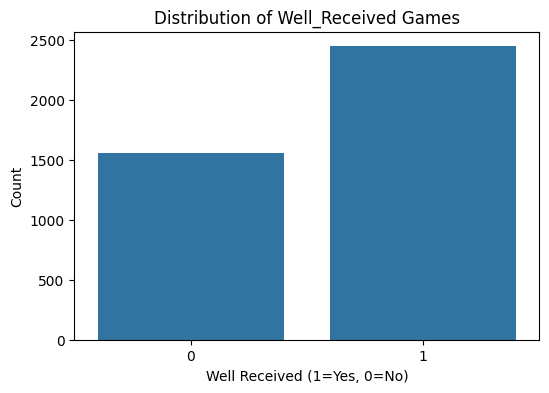

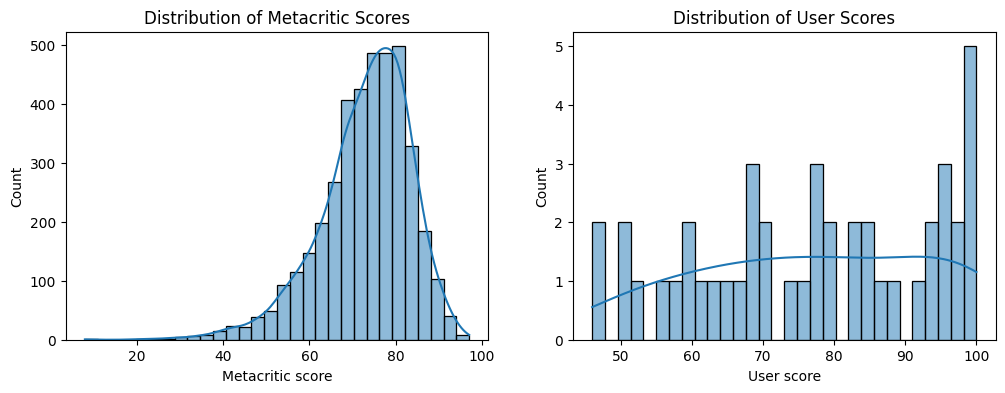

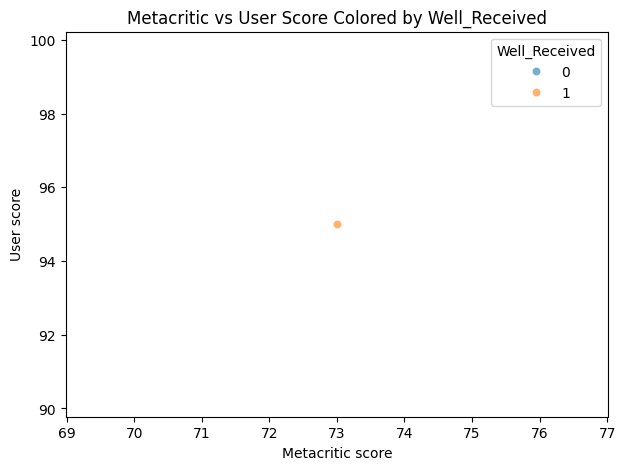

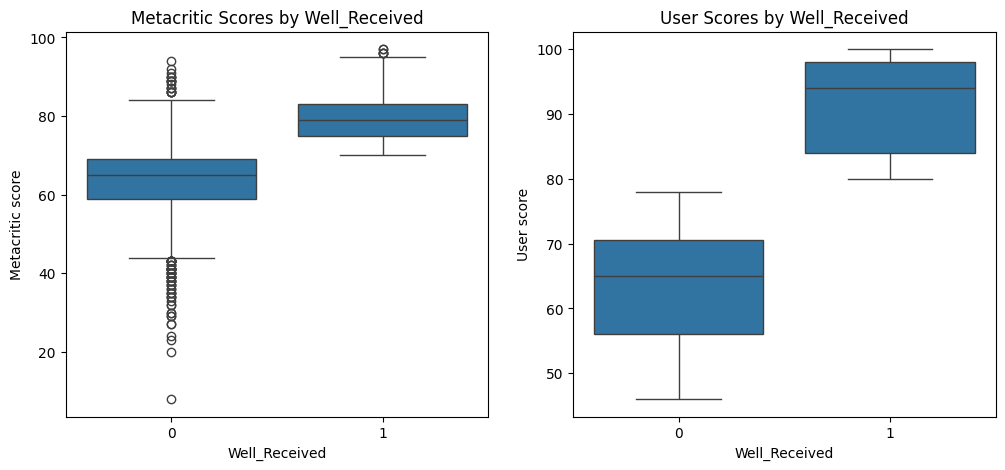

<ipython-input-23-1724791250>:42: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_genres.values, y=top_genres.index, palette='viridis')


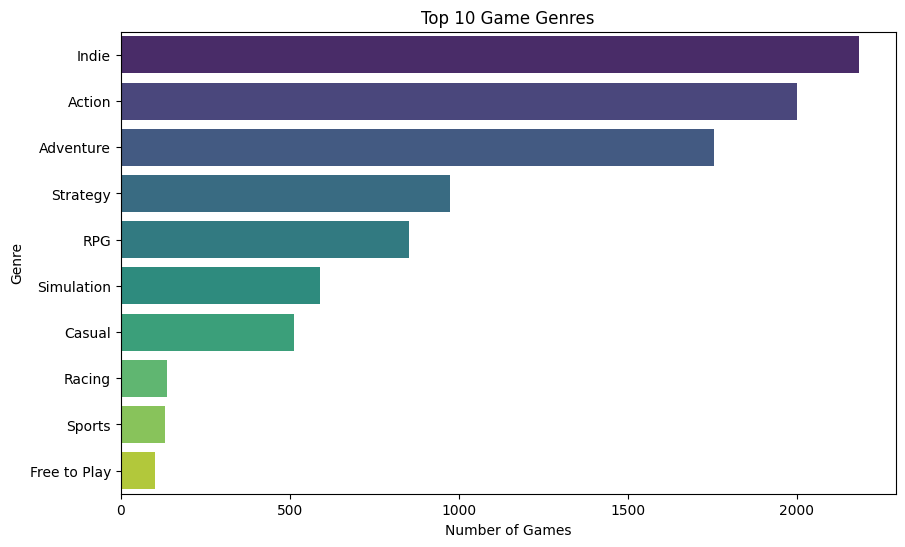

In [23]:
# Distribution of Well_Received
plt.figure(figsize=(6,4))
sns.countplot(x='Well_Received', data=df_filtered)
plt.title('Distribution of Well_Received Games')
plt.xlabel('Well Received (1=Yes, 0=No)')
plt.ylabel('Count')
plt.show()

# Histogram of Metacritic and User Scores
fig, axs = plt.subplots(1, 2, figsize=(12,4))

sns.histplot(df_filtered['Metacritic score'].dropna(), bins=30, kde=True, ax=axs[0])
axs[0].set_title('Distribution of Metacritic Scores')

sns.histplot(df_filtered['User score'].dropna(), bins=30, kde=True, ax=axs[1])
axs[1].set_title('Distribution of User Scores')

plt.show()

# Scatter plot: Metacritic score vs User score
plt.figure(figsize=(7,5))
sns.scatterplot(x='Metacritic score', y='User score', hue='Well_Received', data=df_filtered, alpha=0.6)
plt.title('Metacritic vs User Score Colored by Well_Received')
plt.show()

# Boxplots of Metacritic and User Scores by Well_Received
fig, axs = plt.subplots(1, 2, figsize=(12,5))

sns.boxplot(x='Well_Received', y='Metacritic score', data=df_filtered, ax=axs[0])
axs[0].set_title('Metacritic Scores by Well_Received')

sns.boxplot(x='Well_Received', y='User score', data=df_filtered, ax=axs[1])
axs[1].set_title('User Scores by Well_Received')

plt.show()

# Top 10 genres count plot
all_genres = df_filtered['Genres'].dropna().str.split(',').explode()
top_genres = all_genres.value_counts().nlargest(10)

plt.figure(figsize=(10,6))
sns.barplot(x=top_genres.values, y=top_genres.index, palette='viridis')
plt.title('Top 10 Game Genres')
plt.xlabel('Number of Games')
plt.ylabel('Genre')
plt.show()

In [24]:
# Explode genres into individual rows
df_genres = df_filtered[['Genres', 'Well_Received']].dropna().copy()
df_genres = df_genres.assign(Genre=df_genres['Genres'].str.split(',')).explode('Genre')

# Stripping whitespace just in case
df_genres['Genre'] = df_genres['Genre'].str.strip()

# Group by Genre and calculate proportion of well received
genre_rank = df_genres.groupby('Genre')['Well_Received'].agg(['mean', 'count']).reset_index()

# Rename columns for clarity
genre_rank.columns = ['Genre', 'Well_Received_Rate', 'Count']

# Sort by Well_Received_Rate descending
genre_rank = genre_rank.sort_values(by='Well_Received_Rate', ascending=False)

print(genre_rank.head(20))  # Top 20 genres by well received rate

                    Genre  Well_Received_Rate  Count
15                Unknown            0.800000      5
1               Adventure            0.633979   1754
9                     RPG            0.630715    853
6                   Indie            0.620705   2183
0                  Action            0.610695   2001
14               Strategy            0.606776    974
10                 Racing            0.605839    137
2                  Casual            0.602339    513
3            Early Access            0.600000      5
13                 Sports            0.583333    132
12             Simulation            0.558574    589
7   Massively Multiplayer            0.533333     75
4            Free to Play            0.504854    103
11         Sexual Content            0.500000      2
8                  Nudity            0.333333      3
16                Violent            0.285714      7
5                    Gore            0.000000      1


<ipython-input-25-2367984851>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=genre_rank.head(20), x='Well_Received_Rate', y='Genre', palette='coolwarm')


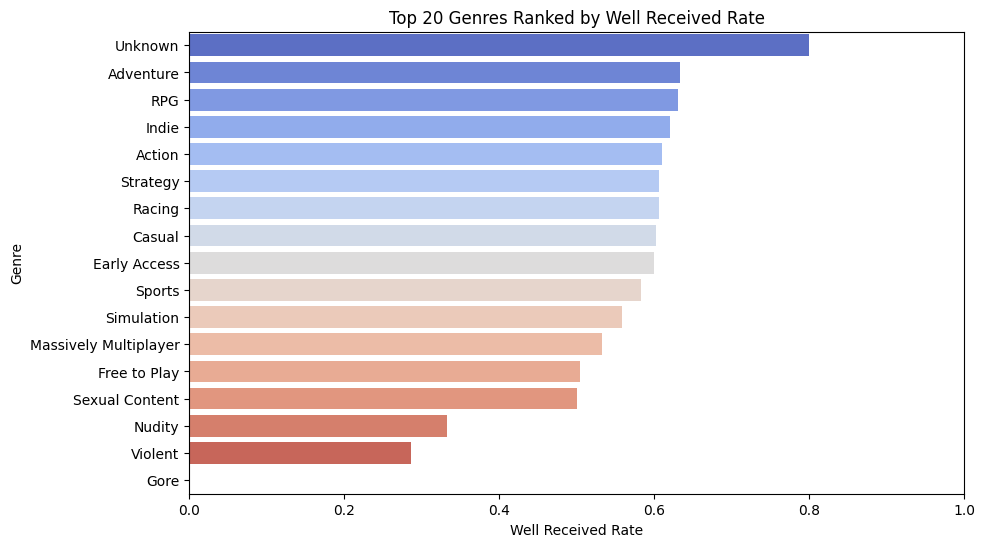

In [25]:
plt.figure(figsize=(10,6))
sns.barplot(data=genre_rank.head(20), x='Well_Received_Rate', y='Genre', palette='coolwarm')
plt.title('Top 20 Genres Ranked by Well Received Rate')
plt.xlabel('Well Received Rate')
plt.ylabel('Genre')
plt.xlim(0,1)
plt.show()

### Feature Engineering

In [26]:
# Copy the filtered dataframe
df_feat = df_filtered.copy()

# Extract release year & game age
df_feat['Release Year'] = df_feat['Release date'].dt.year
df_feat['Game Age'] = 2025 - df_feat['Release Year']

# Platform encoding
df_feat['Windows'] = df_feat['Windows'].astype(int)
df_feat['Mac'] = df_feat['Mac'].astype(int)
df_feat['Linux'] = df_feat['Linux'].astype(int)

# Price binning
def price_bin(price):
    if price == 0:
        return 'Free'
    elif price <= 10:
        return 'Low'
    elif price <= 30:
        return 'Medium'
    else:
        return 'High'

df_feat['Price_bin'] = df_feat['Price'].apply(price_bin)

# MultiLabelBinarizer on Genres
df_feat['Genres_list'] = df_feat['Genres'].str.split(',').apply(lambda x: [g.strip() for g in x] if isinstance(x, list) else [])

mlb_genres = MultiLabelBinarizer()
genres_encoded = mlb_genres.fit_transform(df_feat['Genres_list'])
genres_df = pd.DataFrame(genres_encoded, columns=[f"Genre_{g}" for g in mlb_genres.classes_], index=df_feat.index)

In [49]:
#Starting Tags Feature Engineering (Ethical Focus)")
df_feat['Tags'] = df_feat['Tags'].fillna('Unknown')
#Ajusted lambda function to split and strip tags from strings.
df_feat['Tags_list'] = df_feat['Tags'].apply(lambda x: [t.strip() for t in str(x).split(',')] if pd.notna(x) else [])

mlb_tags = MultiLabelBinarizer()
tags_encoded = mlb_tags.fit_transform(df_feat['Tags_list'])
tags_df = pd.DataFrame(tags_encoded, columns=[f"Tag_{t}" for t in mlb_tags.classes_], index=df_feat.index)

# Filter out very rare tags to reduce dimensionality and potential noise.
# Keeping tags that appear in at least 10 games, we can adjust as needed.
min_tag_occurrences = 3
frequent_tags = tags_df.sum(axis=0)[tags_df.sum(axis=0) >= min_tag_occurrences].index
tags_df_filtered = tags_df[frequent_tags]

print(f"Original number of unique tags: {len(mlb_tags.classes_)}")
print(f"Number of frequent tags (>= {min_tag_occurrences} occurrences) after filtering: {len(frequent_tags)}")
print("Tags Feature Engineering complete.")

Original number of unique tags: 427
Number of frequent tags (>= 3 occurrences) after filtering: 409
Tags Feature Engineering complete.


In [50]:
#Engineer Playtime Ratios (Engagement Features)
print("\n--- Starting Playtime Ratios Feature Engineering (Engagement Focus) ---")
# Calculate ratio of recent playtime to forever playtime.
df_feat['Avg_Playtime_Ratio_Recent_Forever'] = df_feat['Average playtime two weeks'] / (df_feat['Average playtime forever'] + 1)
df_feat['Med_Playtime_Ratio_Recent_Forever'] = df_feat['Median playtime two weeks'] / (df_feat['Median playtime forever'] + 1)

# Handle potential infinite values
df_feat['Avg_Playtime_Ratio_Recent_Forever'] = df_feat['Avg_Playtime_Ratio_Recent_Forever'].replace([np.inf, -np.inf, np.nan], 0)
df_feat['Med_Playtime_Ratio_Recent_Forever'] = df_feat['Med_Playtime_Ratio_Recent_Forever'].replace([np.inf, -np.inf, np.nan], 0)
print("New Playtime Ratio Features created.")


--- Starting Playtime Ratios Feature Engineering (Engagement Focus) ---
New Playtime Ratio Features created.


### Encoding/Scaling/Imputing

In [51]:
# One-hot encode Price_bin
price_dummies = pd.get_dummies(df_feat['Price_bin'], prefix='Price').astype(int)

# Combine all features (Added filtered tags DataFrame &  new playtime ratio features)
features = pd.concat([
    df_feat[['Metacritic score', 'User score', 'Peak CCU', 'Achievements', 'Recommendations',
             'Average playtime forever', 'Average playtime two weeks', 'Median playtime forever', 'Median playtime two weeks',
             'Windows', 'Mac', 'Linux', 'Game Age',
             'Avg_Playtime_Ratio_Recent_Forever', # new playtime ratio feature
             'Med_Playtime_Ratio_Recent_Forever']],#new playtime ratio feature
    genres_df,
    tags_df_filtered, #filtered tags DataFrame
    price_dummies
], axis=1)

# Scaling numeric features
numeric_cols = ['Metacritic score', 'User score', 'Peak CCU', 'Achievements', 'Recommendations',
                'Average playtime forever', 'Average playtime two weeks', 'Median playtime forever', 'Median playtime two weeks',
                'Game Age',
                'Avg_Playtime_Ratio_Recent_Forever', #New playtime ratio added to scaling list
                'Med_Playtime_Ratio_Recent_Forever'] #New playtime ratio added to scaling list

scaler = StandardScaler()

# Imputing for NaN values
for col in numeric_cols:
    if features[col].isna().any():
        median_val = features[col].median()
        features[col] = features[col].fillna(median_val).infer_objects(copy=False)

#Apply StandardScaler to numerical columns.
scaler = StandardScaler()
features[numeric_cols] = scaler.fit_transform(features[numeric_cols])

print(f"\nFinal features DataFrame shape (X for modeling): {features.shape}")
print("\nHead of Final Features DataFrame (showing new features):")
print(features.head())
print("\nData types check for selected columns (including new ones):")
print(features[['Price_Free', 'Price_Low', 'Price_Medium'] +
               list(tags_df_filtered.columns[:min(5, len(tags_df_filtered.columns))]) +
               ['Avg_Playtime_Ratio_Recent_Forever']].dtypes)


Final features DataFrame shape (X for modeling): (4000, 444)

Head of Final Features DataFrame (showing new features):
         Metacritic score  User score  Peak CCU  Achievements  \
1026420         -1.044758    0.003019 -0.402712      0.015186   
22670           -0.855138    0.003019 -0.402712     -0.363682   
231330          -1.898047    0.003019 -0.402712      0.303848   
897820           1.041060    0.003019 -0.402712     -0.417806   
12140            1.515110    0.003019  2.513937     -0.598219   

         Recommendations  Average playtime forever  \
1026420        -0.135487                 -0.317653   
22670          -0.137588                 -0.330550   
231330         -0.124939                 -0.173548   
897820         -0.129747                 -0.308682   
12140          -0.013337                 -0.261021   

         Average playtime two weeks  Median playtime forever  \
1026420                   -0.164246                -0.288140   
22670                     -0.164246 

<ipython-input-51-3716798358>:29: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  features[col] = features[col].fillna(median_val).infer_objects(copy=False)
<ipython-input-51-3716798358>:29: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  features[col] = features[col].fillna(median_val).infer_objects(copy=False)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/extmath.py:1101: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/usr/local/lib/python3.11/dist-packages/sklearn/utils/extmath.py:1

In [52]:
# price is showing as true/false instead of 0/1
price_dummies = pd.get_dummies(df_feat['Price_bin'], prefix='Price').astype(int)

# Double checking target shape
print(features.shape, target.shape)

(4000, 444) (4000,)


In [53]:
# Target shape and features shape is good, now to continue fixing price to be binary vs true/false

# Regenerate dummy columns as ints
price_dummies = pd.get_dummies(df_feat['Price_bin'], prefix='Price').astype(int)

# Rebuild features from scratch
features = pd.concat([
    df_feat[['Metacritic score', 'User score', 'Peak CCU', 'Achievements', 'Recommendations',
             'Average playtime forever', 'Average playtime two weeks', 'Median playtime forever', 'Median playtime two weeks',
             'Windows', 'Mac', 'Linux', 'Game Age']],
    genres_df,
    price_dummies
], axis=1)

# Re-scale numeric features
numeric_cols = ['Metacritic score', 'User score', 'Peak CCU', 'Achievements', 'Recommendations',
                'Average playtime forever', 'Average playtime two weeks', 'Median playtime forever', 'Median playtime two weeks',
                'Game Age']

# Imputing for NaN values
for col in numeric_cols:
    if features[col].isna().any():
        median_val = features[col].median()
        features[col] = features[col].fillna(median_val).infer_objects(copy=False)

features[numeric_cols] = StandardScaler().fit_transform(features[numeric_cols])

print(features[['Price_Free', 'Price_Low', 'Price_Medium']].head())
print(features.dtypes.tail(5))  # double-check they're int64

         Price_Free  Price_Low  Price_Medium
1026420           1          0             0
22670             1          0             0
231330            1          0             0
897820            1          0             0
12140             1          0             0
Genre_Unknown    int64
Genre_Violent    int64
Price_Free       int64
Price_Low        int64
Price_Medium     int64
dtype: object


<ipython-input-53-3408150680>:24: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  features[col] = features[col].fillna(median_val).infer_objects(copy=False)
<ipython-input-53-3408150680>:24: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  features[col] = features[col].fillna(median_val).infer_objects(copy=False)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/extmath.py:1101: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/usr/local/lib/python3.11/dist-packages/sklearn/utils/extmath.py:1

### Modeling

In [54]:
# Create train/test splits
X_train, X_test, y_train, y_test = train_test_split(
    features, target, test_size=0.2, random_state=42, stratify=target
)
print(f"\nTrain set shape (X_train, y_train): {X_train.shape}, {y_train.shape}")
print(f"Test set shape (X_test, y_test): {X_test.shape}, {y_test.shape}")


Train set shape (X_train, y_train): (3200, 33), (3200,)
Test set shape (X_test, y_test): (800, 33), (800,)


In [55]:
# Creating random forest model
print("\nOriginal Random Forest Model Performance (calculated on expanded features)")
rf_original = RandomForestClassifier(n_estimators=100, random_state=42)
rf_original.fit(X_train, y_train)
y_pred_rf_original = rf_original.predict(X_test)
print("Confusion Matrix (Original RF):")
print(confusion_matrix(y_test, y_pred_rf_original))
print("Classification Report (Original RF):")
print(classification_report(y_test, y_pred_rf_original))


Original Random Forest Model Performance (calculated on expanded features)
Confusion Matrix (Original RF):
[[260  51]
 [  6 483]]
Classification Report (Original RF):
              precision    recall  f1-score   support

           0       0.98      0.84      0.90       311
           1       0.90      0.99      0.94       489

    accuracy                           0.93       800
   macro avg       0.94      0.91      0.92       800
weighted avg       0.93      0.93      0.93       800




Top 15 Feature Importances (Original RF - calculated on expanded features):
                       feature  importance
0             Metacritic score    0.592607
4              Recommendations    0.100150
5     Average playtime forever    0.058905
7      Median playtime forever    0.053856
3                 Achievements    0.047051
6   Average playtime two weeks    0.019116
8    Median playtime two weeks    0.018384
19                 Genre_Indie    0.010104
10                         Mac    0.009905
1                   User score    0.009826
14             Genre_Adventure    0.009347
13                Genre_Action    0.009110
27              Genre_Strategy    0.008382
2                     Peak CCU    0.008099
11                       Linux    0.008069


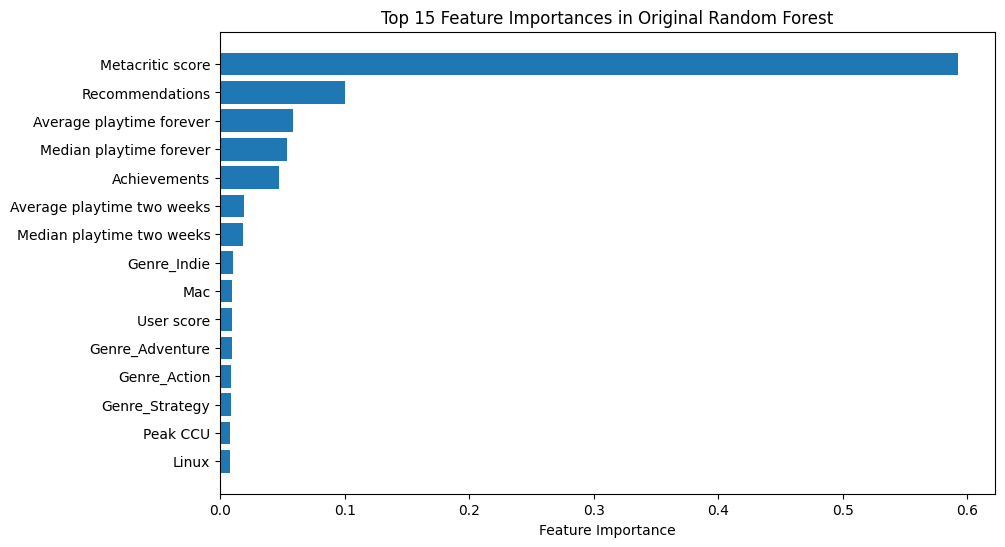

In [56]:
# Defining feature importances
importances = rf.feature_importances_

# Create a DataFrame with feature names and their importances
importances_original = rf_original.feature_importances_
feature_importances_original = pd.DataFrame({
    'feature': features.columns,
    'importance': importances_original
}).sort_values(by='importance', ascending=False)

# Sort features by importance descending
feature_importances = feature_importances.sort_values(by='importance', ascending=False)


# Display the top 15 most important features
print("\nTop 15 Feature Importances (Original RF - calculated on expanded features):")
print(feature_importances_original.head(15))

# Plot the top 15 feature importances
plt.figure(figsize=(10,6))
plt.barh(feature_importances_original['feature'][:15][::-1], feature_importances_original['importance'][:15][::-1])
plt.xlabel('Feature Importance')
plt.title('Top 15 Feature Importances in Original Random Forest')
plt.show()

The feature importance results are pretty telling. The Metacritic score stands out as the most influential factor by far, accounting for nearly 60% of the importance, which makes sense since it’s a solid overall measure of game quality. Recommendations and the different playtime metrics also carry a lot of weight, showing that how much and how long people play a game really reflects its reception. Achievements add some value too, likely because they hint at player engagement or game depth. Genre tags like Indie, Adventure, Action, and Strategy matter but to a lesser degree, which suggests the type of game influences how well it’s received. Platform indicators like Mac and Linux have a small effect, probably reflecting differences in player bases on those systems. Overall, it’s clear that a mix of quality scores, player activity, and game characteristics all contribute to predicting if a game is well received.

# Random Forest Hyperparameter Tuning

In [57]:
print("\n--- Starting Random Forest Hyperparameter Tuning ---")
print("This process explores different combinations of hyperparameters for the Random Forest model.")
print("It can be computationally intensive and may take some time depending on the grid and data size.")


--- Starting Random Forest Hyperparameter Tuning ---
This process explores different combinations of hyperparameters for the Random Forest model.
It can be computationally intensive and may take some time depending on the grid and data size.


In [58]:
# Define the parameter grid to search for optimal hyperparameters
param_grid = {
    'n_estimators': [100, 200], # Number of trees in the forest
    'max_features': ['sqrt'], # Number of features to consider when looking for the best split
    'max_depth': [10, 20, None], # Maximum depth of the tree
    'min_samples_split': [2, 5], # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2] # Minimum number of samples required to be at a leaf node
}

# Initialize GridSearchCV for hyperparameter tuning
grid_search = GridSearchCV(estimator=RandomForestClassifier(random_state=42),
                           param_grid=param_grid,
                           cv=3,
                           n_jobs=-1, # Use all available CPU cores
                           verbose=2, # Verbose output
                           scoring='f1_weighted') # Metric to optimize for (F1-score, weighted by class support)

# Fit GridSearchCV to the training data. This performs the exhaustive grid search and cross-validation.
grid_search.fit(X_train, y_train)

# Print the best combination of hyperparameters found by the grid search
print(f"\nBest Random Forest Parameters found by GridSearchCV: {grid_search.best_params_}")
# Print the corresponding best cross-validation score (F1-weighted)
print(f"Best Cross-Validation Score (F1-weighted): {grid_search.best_score_:.4f}")

Fitting 3 folds for each of 24 candidates, totalling 72 fits

Best Random Forest Parameters found by GridSearchCV: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Best Cross-Validation Score (F1-weighted): 0.9283



--- Classification Report for Tuned Random Forest ---
              precision    recall  f1-score   support

           0       1.00      0.82      0.90       311
           1       0.90      1.00      0.94       489

    accuracy                           0.93       800
   macro avg       0.95      0.91      0.92       800
weighted avg       0.94      0.93      0.93       800


--- Top 15 Feature Importances (from Tuned Random Forest) ---
                       feature  importance
0             Metacritic score    0.671718
4              Recommendations    0.090752
5     Average playtime forever    0.046697
7      Median playtime forever    0.032633
3                 Achievements    0.030024
6   Average playtime two weeks    0.022806
8    Median playtime two weeks    0.022686
1                   User score    0.010067
10                         Mac    0.009901
19                 Genre_Indie    0.007576
11                       Linux    0.006362
2                     Peak CCU    0.005

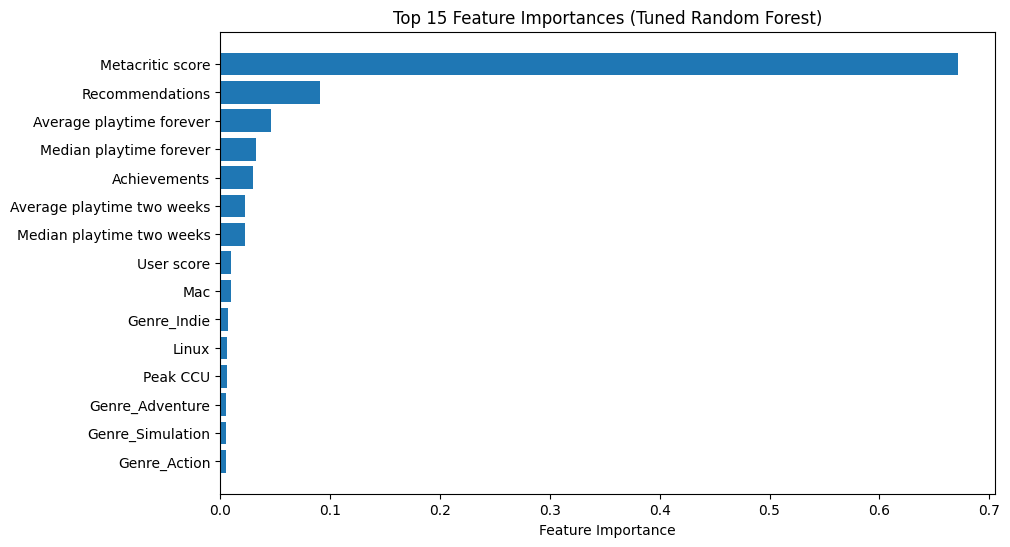

In [59]:
# Get the best estimator (the trained RandomForestClassifier with the optimal hyperparameters)
best_rf_tuned = grid_search.best_estimator_

# Make predictions on the unseen test set using the best tuned model
y_pred_best_rf_tuned = best_rf_tuned.predict(X_test)

print("\n--- Classification Report for Tuned Random Forest ---")
print(classification_report(y_test, y_pred_best_rf_tuned))

# Get and display feature importances for the best tuned model
print("\n--- Top 15 Feature Importances (from Tuned Random Forest) ---")
importances_tuned = best_rf_tuned.feature_importances_
feature_importances_tuned = pd.DataFrame({
    'feature': features.columns,
    'importance': importances_tuned
}).sort_values(by='importance', ascending=False)
print(feature_importances_tuned.head(15))

# Optional: Plot feature importances for the tuned model
plt.figure(figsize=(10,6))
plt.barh(feature_importances_tuned['feature'][:15][::-1], feature_importances_tuned['importance'][:15][::-1])
plt.xlabel('Feature Importance')
plt.title('Top 15 Feature Importances (Tuned Random Forest)')
plt.show()

# Analysis of Ethically/Problematic Tags

In [61]:
print("\n--- Analysis of Ethically Problematic Tags ---")

# Define a list of tags that are potentially ethically problematic (We can expand on this list)
problematic_tags_to_check = [
    'Grind', 'Microtransactions', 'Loot Box', 'Pay to Win', 'Addictive',
    'F2P', 'Free to Play', 'P2W', 'Casino', 'Gacha'
]

# Create a list of the actual feature names to look for in the 'features' DataFrame
problematic_feature_names = [f"Tag_{tag}" for tag in problematic_tags_to_check]

print("\nImportance of Potentially Problematic Tags (from Tuned Random Forest Model):")
found_problematic_tags = False
for tag_feature_name in problematic_feature_names:
    if tag_feature_name in feature_importances_tuned['feature'].values:
        importance = feature_importances_tuned[feature_importances_tuned['feature'] == tag_feature_name]['importance'].iloc[0]
        print(f"- Importance of '{tag_feature_name}': {importance:.4f}")
        found_problematic_tags = True
    else:
        # The tag might not be in the top 'min_tag_occurrences' (3) or not in the dataset at all.
        print(f"- Tag feature '{tag_feature_name}' not found in the final feature set (too rare or not present in data).")

if not found_problematic_tags:
    print("\nNo explicitly problematic tag features were found in the model's feature importances.")
    print("This might mean these tags are not very predictive of 'well-received' status,")
    print("or that the underlying data for these tags is sparse/not well-represented.")
    print("Further qualitative analysis might be needed to assess ethical implications.")


--- Analysis of Ethically Problematic Tags ---

Importance of Potentially Problematic Tags (from Tuned Random Forest Model):
- Tag feature 'Tag_Grind' not found in the final feature set (too rare or not present in data).
- Tag feature 'Tag_Microtransactions' not found in the final feature set (too rare or not present in data).
- Tag feature 'Tag_Loot Box' not found in the final feature set (too rare or not present in data).
- Tag feature 'Tag_Pay to Win' not found in the final feature set (too rare or not present in data).
- Tag feature 'Tag_Addictive' not found in the final feature set (too rare or not present in data).
- Tag feature 'Tag_F2P' not found in the final feature set (too rare or not present in data).
- Tag feature 'Tag_Free to Play' not found in the final feature set (too rare or not present in data).
- Tag feature 'Tag_P2W' not found in the final feature set (too rare or not present in data).
- Tag feature 'Tag_Casino' not found in the final feature set (too rare or not 

In [62]:
### --- Hyperparameter Tuning for Random Forest WITHOUT Metacritic for this specific model ---
print("\n--- Starting Random Forest Hyperparameter Tuning (without Metacritic) ---")
print("This process explores different combinations of hyperparameters for the Random Forest model.")
print("It is specifically trained on a feature set *excluding Metacritic score* to highlight other drivers.")
print("It can be computationally intensive and may take some time depending on the grid and data size.")

#Create feature sets WITHOUT Metacritic for this specific model
X_train_no_metacritic = X_train.drop(columns=['Metacritic score'], errors='ignore')
X_test_no_metacritic = X_test.drop(columns=['Metacritic score'], errors='ignore')
print("\nCreated new training/testing sets excluding 'Metacritic score' for tuned model.")

# Define the parameter grid to search for optimal hyperparameters
param_grid = {
    'n_estimators': [100, 200],
    'max_features': ['sqrt'],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

# Initialize GridSearchCV for hyperparameter tuning
grid_search = GridSearchCV(estimator=RandomForestClassifier(random_state=42),
                           param_grid=param_grid,
                           cv=3,
                           n_jobs=-1,
                           verbose=2,
                           scoring='f1_weighted')

# Fit GridSearchCV to the training data and cross-validation. Used X_train_no_metacritic here
grid_search.fit(X_train_no_metacritic, y_train)

# Print the best combination of hyperparameters found by the grid search
print(f"\nBest Random Forest Parameters found by GridSearchCV: {grid_search.best_params_}")
# Print the corresponding best cross-validation score (F1-weighted)
print(f"Best Cross-Validation Score (F1-weighted): {grid_search.best_score_:.4f}")



--- Starting Random Forest Hyperparameter Tuning (without Metacritic) ---
This process explores different combinations of hyperparameters for the Random Forest model.
It is specifically trained on a feature set *excluding Metacritic score* to highlight other drivers.
It can be computationally intensive and may take some time depending on the grid and data size.

Created new training/testing sets excluding 'Metacritic score' for tuned model.
Fitting 3 folds for each of 24 candidates, totalling 72 fits

Best Random Forest Parameters found by GridSearchCV: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
Best Cross-Validation Score (F1-weighted): 0.7009



--- Classification Report for Tuned Random Forest (without Metacritic) ---
              precision    recall  f1-score   support

           0       0.58      0.49      0.53       311
           1       0.71      0.78      0.74       489

    accuracy                           0.67       800
   macro avg       0.65      0.63      0.64       800
weighted avg       0.66      0.67      0.66       800


--- Top 15 Feature Importances (from Tuned Random Forest, without Metacritic) ---
                       feature  importance
3              Recommendations    0.300869
4     Average playtime forever    0.136865
6      Median playtime forever    0.116070
2                 Achievements    0.097397
5   Average playtime two weeks    0.072821
7    Median playtime two weeks    0.055724
9                          Mac    0.032692
18                 Genre_Indie    0.020594
10                       Linux    0.020316
13             Genre_Adventure    0.018840
24            Genre_Simulation    0.01828

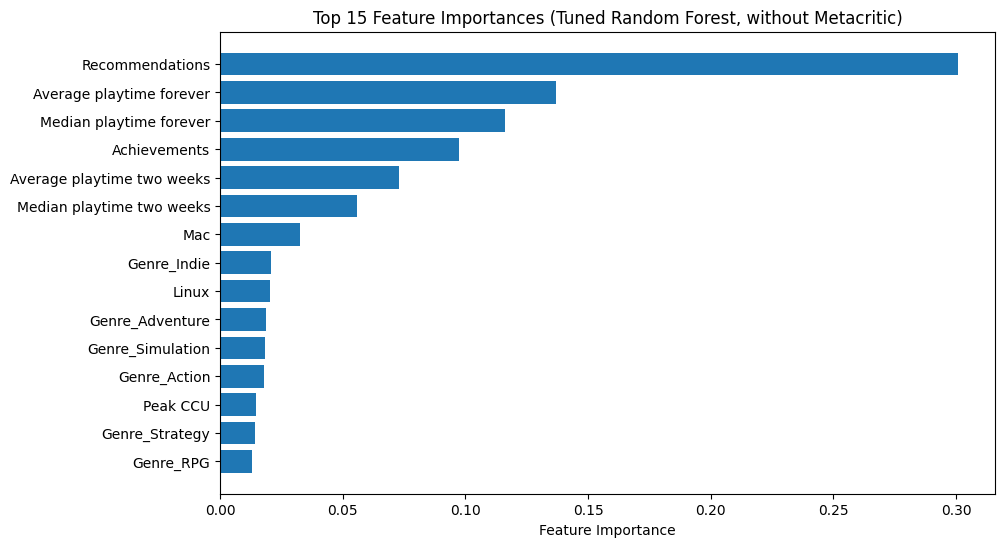

In [63]:
# Get the best estimator (the trained RandomForestClassifier with the optimal hyperparameters)
best_rf_tuned = grid_search.best_estimator_

# Make predictions on the unseen test set using the best tuned model
y_pred_best_rf_tuned = best_rf_tuned.predict(X_test_no_metacritic)

print("\n--- Classification Report for Tuned Random Forest (without Metacritic) ---")
print(classification_report(y_test, y_pred_best_rf_tuned))

# Get and display feature importances for the best tuned model
print("\n--- Top 15 Feature Importances (from Tuned Random Forest, without Metacritic) ---")
importances_tuned = best_rf_tuned.feature_importances_
feature_importances_tuned = pd.DataFrame({
    #Adjust feature names to match the set used by this specific model
    'feature': X_train_no_metacritic.columns,
    'importance': importances_tuned
}).sort_values(by='importance', ascending=False)
print(feature_importances_tuned.head(15))

#Plot feature importances for the tuned model
plt.figure(figsize=(10,6))
plt.barh(feature_importances_tuned['feature'][:15][::-1], feature_importances_tuned['importance'][:15][::-1])
plt.xlabel('Feature Importance')
plt.title('Top 15 Feature Importances (Tuned Random Forest, without Metacritic)')
plt.show()

# Analysis of Ethically Problematic Tags

In [64]:
# Define a list of tags that are potentially ethically problematic ("grindy" loops, "pay-to-win" mechanics, or other concerns.)
problematic_tags_to_check = [
    'Grind', 'Microtransactions', 'Loot Box', 'Pay to Win', 'Addictive',
    'F2P', 'Free to Play', 'P2W', 'Casino', 'Gacha' # Expand common related terms as needed
]

# Create a list of the feature names to look for in the 'features' DataFrame ()'Tag_Grind', 'Tag_Microtransactions', etc.)
problematic_feature_names = [f"Tag_{tag}" for tag in problematic_tags_to_check]

print("\nImportance of Potentially Problematic Tags (from Tuned Random Forest Model):")
found_problematic_tags = False
for tag_feature_name in problematic_feature_names:
    # DataFrame now reflects the model trained WITHOUT Metacritic.
    if tag_feature_name in feature_importances_tuned['feature'].values:
        importance = feature_importances_tuned[feature_importances_tuned['feature'] == tag_feature_name]['importance'].iloc[0]
        print(f"- Importance of '{tag_feature_name}': {importance:.4f}")
        found_problematic_tags = True
    else:
        # This means the tag might not be in the top 'min_tag_occurrences' (10) or not in the dataset at all.
        print(f"- Tag feature '{tag_feature_name}' not found in the final feature set (too rare or not present in data).")

if not found_problematic_tags:
    print("\nNo explicitly problematic tag features were found in the model's feature importances.")
    print("This might mean these tags are not very predictive of 'well-received' status,")
    print("or that the underlying data for these tags is sparse/not well-represented.")
    print("Further qualitative analysis might be needed to assess ethical implications.")



Importance of Potentially Problematic Tags (from Tuned Random Forest Model):
- Tag feature 'Tag_Grind' not found in the final feature set (too rare or not present in data).
- Tag feature 'Tag_Microtransactions' not found in the final feature set (too rare or not present in data).
- Tag feature 'Tag_Loot Box' not found in the final feature set (too rare or not present in data).
- Tag feature 'Tag_Pay to Win' not found in the final feature set (too rare or not present in data).
- Tag feature 'Tag_Addictive' not found in the final feature set (too rare or not present in data).
- Tag feature 'Tag_F2P' not found in the final feature set (too rare or not present in data).
- Tag feature 'Tag_Free to Play' not found in the final feature set (too rare or not present in data).
- Tag feature 'Tag_P2W' not found in the final feature set (too rare or not present in data).
- Tag feature 'Tag_Casino' not found in the final feature set (too rare or not present in data).
- Tag feature 'Tag_Gacha' not 

**Metacritic's Influence:** Its overwhelming impact (nearly 70%) means prioritizing game quality for strong critic scores, which should be central to marketing.

**Alternative Marketing:** For games with lower critic reception, marketing should emphasize community engagement and alternative angles.

**Player Engagement:** Positive gamer reviews and sustained playtime metrics (including new ratios) are crucial for post-launch success.

**Long-Term Design:** Developers must design for ongoing engagement through compelling content and robust community management, fostering retention and word-of-mouth.

**Ethical Tag Analysis:** While problematic tags (e.g., 'Grind', 'Pay to Win') weren't top predictors of overall reception, businesses must still critically assess how engagement is achieved to avoid reputational damage, recognizing the nuanced impact of these features.



In Conclusion, our project highlights Metacritic's significant role in game reception, but also reveals that strong player engagement (recommendations, playtime) is crucial even without critic scores. While common 'problematic' tags didn't show high predictive power, this suggests a nuanced interplay of factors beyond initial assumptions, offering valuable insights for ethically aware game development.
